In [19]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

In [20]:
def generate_base_dataset(n=100):
    """Generate the original dataset that will be subsampled"""
    mA = np.array([1.0, 0.3])
    sigmaA = 0.2
    mB = np.array([0.0, -0.1])
    sigmaB = 0.3
    
    # Initialize with bias term
    classA = np.ones((n, 3))
    half_n = round(0.5 * n)
    
    # Generate split distribution for class A
    classA[:half_n, 0] = np.random.randn(half_n) * sigmaA - mA[0]
    classA[half_n:, 0] = np.random.randn(n - half_n) * sigmaA + mA[0]
    classA[:, 1] = np.random.randn(n) * sigmaA + mA[1]
    
    classB = np.ones((n, 3))
    classB[:, 0] = np.random.randn(n) * sigmaB + mB[0]
    classB[:, 1] = np.random.randn(n) * sigmaB + mB[1]
    
    return classA, classB

In [21]:
def subsample_data(classA, classB, scenario):
    """Create a subsampled version of the data"""
    classA_sub = deepcopy(classA)
    classB_sub = deepcopy(classB)
    n = len(classA)
    
    if scenario == 'random_25':
        num_remove = int(0.25 * n)
        remove_idx_A = np.random.choice(n, num_remove, replace=False)
        remove_idx_B = np.random.choice(n, num_remove, replace=False)
        classA_sub = np.delete(classA_sub, remove_idx_A, axis=0)
        classB_sub = np.delete(classB_sub, remove_idx_B, axis=0)
    elif scenario == 'classA_50':
        num_remove = int(0.5 * n)
        remove_idx = np.random.choice(n, num_remove, replace=False)
        classA_sub = np.delete(classA_sub, remove_idx, axis=0)
    elif scenario == 'classB_50':
        num_remove = int(0.5 * n)
        remove_idx = np.random.choice(n, num_remove, replace=False)
        classB_sub = np.delete(classB_sub, remove_idx, axis=0)
    elif scenario == 'classA_split':
        left_idx = np.where(classA_sub[:, 0] < 0)[0]
        right_idx = np.where(classA_sub[:, 0] > 0)[0]
        num_remove_left = int(0.2 * len(left_idx))
        num_remove_right = int(0.8 * len(right_idx))
        remove_idx_left = np.random.choice(left_idx, num_remove_left, replace=False)
        remove_idx_right = np.random.choice(right_idx, num_remove_right, replace=False)
        remove_idx = np.concatenate([remove_idx_left, remove_idx_right])
        classA_sub = np.delete(classA_sub, remove_idx, axis=0)
    
    return classA_sub, classB_sub

In [22]:
def prepare_data(classA, classB):
    """Prepare data for training"""
    X = np.vstack((classA, classB))
    T = np.hstack((np.ones(len(classA)), -np.ones(len(classB))))
    perm = np.random.permutation(len(X))
    return X[perm].T, T[perm], len(classA), len(classB)

In [23]:
def evaluate_perceptron(W, X, T, len_A, len_B):
    """Evaluate perceptron performance"""
    T_pred = np.dot(W, X)
    
    # Calculate class-specific accuracies
    acc_A = np.mean(T_pred[:len_A] > 0)
    acc_B = np.mean(T_pred[len_B:] < 0)
    
    # Calculate sensitivity and specificity
    sensitivity = acc_A  # True Positive Rate for class A
    specificity = acc_B  # True Negative Rate for class B
    
    return {
        'acc_A': acc_A,
        'acc_B': acc_B,
        'sensitivity': sensitivity,
        'specificity': specificity
    }

In [24]:
def train_perceptron(X, T, len_A, len_B, epochs=20, lr=0.001, verbose=True):
    """Train perceptron using delta rule in batch mode"""
    # Generate random weights (input dimension)
    W = np.random.randn(X.shape[0])
    W[2] = 1  # Initialize bias weight
    
    errors_history = []
    
    for epoch in range(1, epochs + 1):
        # Forward pass
        T_pred = np.dot(W, X)
        
        # Calculate errors
        errors = T - T_pred
        mse = np.mean(errors**2)
        errors_history.append(mse)
        
        # Update weights using delta rule
        W += lr * errors @ X.T
        
        if verbose and epoch % 5 == 0:
            acc_A = np.mean(T_pred[:len_A] > 0)
            acc_B = np.mean(T_pred[len_B:] < 0)
            print(f"Epoch {epoch}: MSE = {mse:.6f}, Class A acc = {acc_A:.3f}, Class B acc = {acc_B:.3f}")
    
    return W, errors_history

In [25]:
def run_subsampling_experiment(n_trials=5):
    """Run the complete subsampling experiment"""
    scenarios = ['random_25', 'classA_50', 'classB_50', 'classA_split']
    results = {scenario: [] for scenario in scenarios}
    
    # Generate original dataset
    classA_orig, classB_orig = generate_base_dataset()
    
    # Plot original data
    plt.figure(figsize=(10, 7))
    plt.scatter(classA_orig[:, 0], classA_orig[:, 1], label='Class A')
    plt.scatter(classB_orig[:, 0], classB_orig[:, 1], label='Class B')
    plt.title('Original Dataset')
    plt.legend()
    plt.show()
    
    # Run trials for each scenario
    for scenario in scenarios:
        print(f"\nRunning {scenario} scenario:")
        
        for trial in range(n_trials):
            # Subsample the original data
            classA_sub, classB_sub = subsample_data(classA_orig, classB_orig, scenario)
            X, T, len_A, len_B = prepare_data(classA_sub, classB_sub)
            
            # Train perceptron
            W, errors = train_perceptron(X, T, len_A, len_B, epochs=20, lr=0.001, verbose=False)
            
            # Evaluate on both training and held-out data
            train_metrics = evaluate_perceptron(W, X, T, len_A, len_B)
            
            # Also evaluate on the original full dataset
            X_full, T_full, len_A_full, len_B_full = prepare_data(classA_orig, classB_orig)
            full_metrics = evaluate_perceptron(W, X_full, T_full, len_A_full, len_B_full)
            
            results[scenario].append({
                'train_metrics': train_metrics,
                'full_metrics': full_metrics,
                'weights': W,
                'errors': errors
            })
            
            print(f"Trial {trial + 1}:")
            print(f"  Training - Class A acc: {train_metrics['acc_A']:.3f}, Class B acc: {train_metrics['acc_B']:.3f}")
            print(f"  Full Set - Class A acc: {full_metrics['acc_A']:.3f}, Class B acc: {full_metrics['acc_B']:.3f}")
    
    return results

In [26]:
def analyze_results(results):
    """Analyze and visualize the experimental results"""
    scenarios = list(results.keys())
    
    # Prepare average metrics
    avg_metrics = {scenario: {
        'train_acc_A': np.mean([trial['train_metrics']['acc_A'] for trial in results[scenario]]),
        'train_acc_B': np.mean([trial['train_metrics']['acc_B'] for trial in results[scenario]]),
        'full_acc_A': np.mean([trial['full_metrics']['acc_A'] for trial in results[scenario]]),
        'full_acc_B': np.mean([trial['full_metrics']['acc_B'] for trial in results[scenario]])
    } for scenario in scenarios}
    
    # Plot comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    x = np.arange(len(scenarios))
    width = 0.35
    
    # Training accuracy
    ax1.bar(x - width/2, [avg_metrics[s]['train_acc_A'] for s in scenarios], width, label='Class A')
    ax1.bar(x + width/2, [avg_metrics[s]['train_acc_B'] for s in scenarios], width, label='Class B')
    ax1.set_title('Training Set Accuracy')
    ax1.set_xticks(x)
    ax1.set_xticklabels(scenarios, rotation=45)
    ax1.legend()
    
    # Full set accuracy
    ax2.bar(x - width/2, [avg_metrics[s]['full_acc_A'] for s in scenarios], width, label='Class A')
    ax2.bar(x + width/2, [avg_metrics[s]['full_acc_B'] for s in scenarios], width, label='Class B')
    ax2.set_title('Full Set Accuracy')
    ax2.set_xticks(x)
    ax2.set_xticklabels(scenarios, rotation=45)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    return avg_metrics

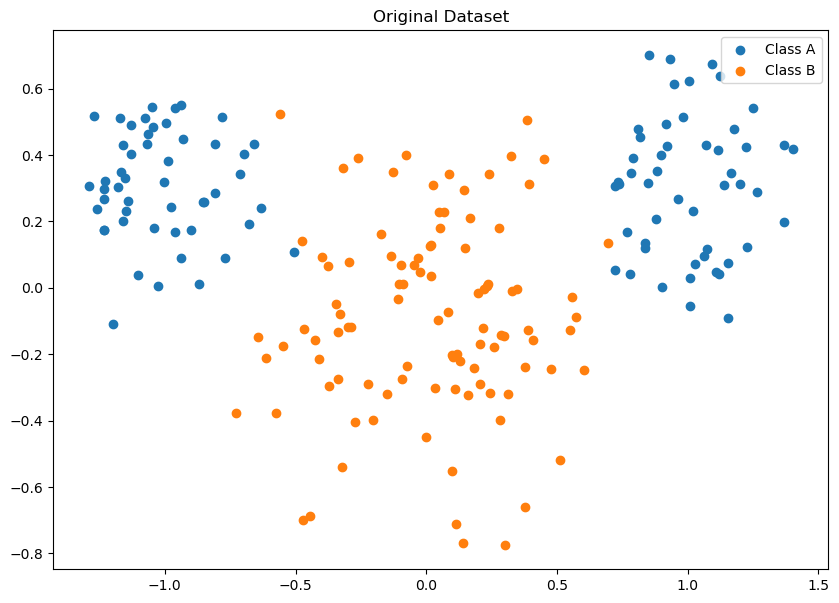


Running random_25 scenario:
Trial 1:
  Training - Class A acc: 0.667, Class B acc: 0.507
  Full Set - Class A acc: 0.570, Class B acc: 0.400
Trial 2:
  Training - Class A acc: 0.520, Class B acc: 0.413
  Full Set - Class A acc: 0.540, Class B acc: 0.460
Trial 3:
  Training - Class A acc: 0.680, Class B acc: 0.320
  Full Set - Class A acc: 0.660, Class B acc: 0.290
Trial 4:
  Training - Class A acc: 0.600, Class B acc: 0.333
  Full Set - Class A acc: 0.580, Class B acc: 0.280
Trial 5:
  Training - Class A acc: 0.773, Class B acc: 0.373
  Full Set - Class A acc: 0.740, Class B acc: 0.320

Running classA_50 scenario:
Trial 1:
  Training - Class A acc: 0.260, Class B acc: 0.660
  Full Set - Class A acc: 0.340, Class B acc: 0.600
Trial 2:
  Training - Class A acc: 0.040, Class B acc: 0.960
  Full Set - Class A acc: 0.130, Class B acc: 0.920
Trial 3:
  Training - Class A acc: 0.320, Class B acc: 0.740
  Full Set - Class A acc: 0.200, Class B acc: 0.740
Trial 4:
  Training - Class A acc: 0.0

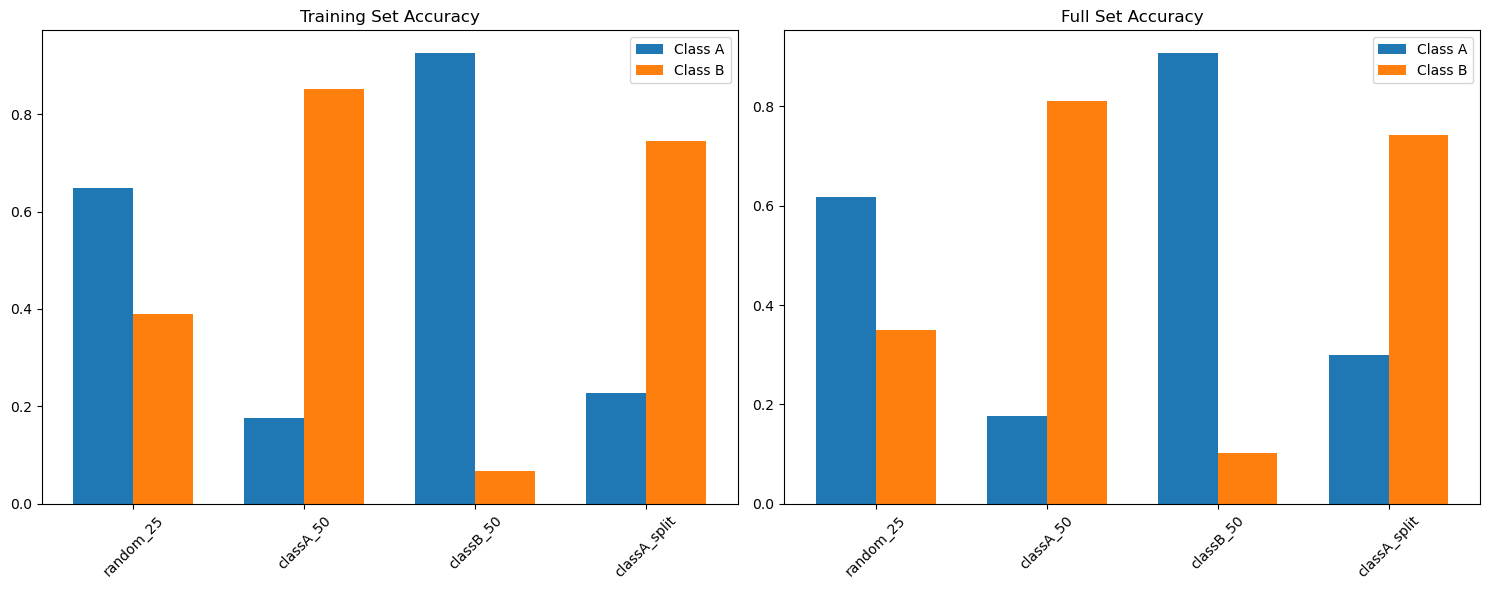

In [27]:
# Run the experiment
results = run_subsampling_experiment(n_trials=5)
metrics = analyze_results(results)